In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [9]:
path = '/home/ofir/ofir_code/crystoper/data/pdb_data/parsed_data.csv'

In [10]:
def print_all(data, n):
    for i, v in enumerate(data):
        
        print(v)
        
        if i == n:
            break

In [11]:
df_pe = pd.read_csv(path)
df_pe.head()

,pdb_id,pe_index,sequence,poly_type,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,1,MDVIGERIKRIKEEHNSTWHYDDENPYKTWAYHGSYEVKATGSASS...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",7.5,293.00,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,1,MEYRYDDNATNVKAMKYLIEHYFDNFKVDSIEIIGSGYDSVAYLVN...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.5,296.00,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
2,6IQ4,6,ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTG...,DNA,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,291.15,"manganese chloride, potassium chloride, potass...",2018-11-06T00:00:00+0000,2024-03-27T00:00:00+0000
3,4IQJ,4,MGSKLKFAHLHQHTQFSLLDGAAKLQDLLKWVKETTPEDPALAMTD...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",8.8,298.00,"0.1 M TRIS pH 8.8, 18% (w/v) polyethylene glyc...",2013-01-11T00:00:00+0000,2023-09-20T00:00:00+0000
4,4IQW,1,HMSPSPVPGSQNVPAPAVKKISQYACQRRTTLNNYNQLFTDALDIL...,Protein,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,293.00,"20% PEG4000, 200 mM sodium formate, 100 mM MES...",2013-01-13T00:00:00+0000,2023-09-20T00:00:00+0000


# features in the data in the data
* pdb_id - id of the entry 
* pe_index - id of the polymer entity (a sub-unit in an entry)
* sequence - the sequence of a polymer entity
* poly_type - type of polymeric entity
* struct_method - method used to detrmine the crystal structure 
* crystal_method - method used to create the structure
* ph - pH in the buffer durring crystallization
* temp - temperature (in K) in the buffer durring crystallization
* pdbx_details - free text describing the crystallization process and the buffer reagents.
* deposit_date - date of structure deposit in the PDB.
* revision_date - date of last revision of the entry in the PDB.



# PDB structure, "entry" and "polymer entity"
A single PDB structure (AKA entry) can have multiple separate polymeric subunits (AKA polymer entities).

Poly entities of the same PDB entry will have exactly same info in all features except 'pe_index', 'sequence' and 'poly_type' 

this is because all entities of a single entry were crystalize together in the same assay.

In [15]:
#we will get a df of entries alone 
cols = list(df_pe.columns)
cols = [col for col in cols if col not in ('pe_index', 'sequence', 'poly_type')]
df_entries = df_pe[cols].drop_duplicates()
df_entries

,pdb_id,struct_method,crystal_method,ph,temp,pdbx_details,deposit_date,revision_date
0,5IQ6,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",7.5,293.00,"HEPES pH7.5, PAA (poly acrilic acid) 20%, MgCl...",2016-03-10T00:00:00+0000,2024-05-08T00:00:00+0000
1,5IQB,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.5,296.00,"80-120mM MgCl2, 8% glycerol, 10% PEG 3350, 100...",2016-03-10T00:00:00+0000,2023-09-27T00:00:00+0000
2,6IQ4,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,291.15,"manganese chloride, potassium chloride, potass...",2018-11-06T00:00:00+0000,2024-03-27T00:00:00+0000
3,4IQJ,X-RAY DIFFRACTION,"VAPOR DIFFUSION, SITTING DROP",8.8,298.00,"0.1 M TRIS pH 8.8, 18% (w/v) polyethylene glyc...",2013-01-11T00:00:00+0000,2023-09-20T00:00:00+0000
4,4IQW,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",6.0,293.00,"20% PEG4000, 200 mM sodium formate, 100 mM MES...",2013-01-13T00:00:00+0000,2023-09-20T00:00:00+0000
...,...,...,...,...,...,...,...,...
291874,3L9V,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",7.0,293.00,"1.45M sodium malonate, 0.5% (w/v) Jeffamine ED...",2010-01-05T00:00:00+0000,2017-11-01T00:00:00+0000
291875,7L9Q,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",8.6,298.00,"23% PEG3350, 100 mM Tris-HCl, pH 8.6, 200 mM m...",2021-01-04T00:00:00+0000,2023-10-18T00:00:00+0000
291876,4L9D,X-RAY DIFFRACTION,"VAPOR DIFFUSION, HANGING DROP",5.5,291.00,"1.2 M sodium citrate and 20% (w/v) PEG 8K, pH ...",2013-06-18T00:00:00+0000,2024-02-28T00:00:00+0000
291877,1L96,X-RAY DIFFRACTION,NaN,NaN,NaN,NaN,1992-02-11T00:00:00+0000,2024-02-14T00:00:00+0000


In [16]:
print(f"In total the data contains {df_entries.shape[0]} PDB structures (entries) that are made of {df_pe.shape[0]} polymer entities")

In total the data contains 188770 PDB structures (entries) that are made of 291880 polymer entities


In [17]:
# The data was filter for X-DAY only when fetching. yet - we want to validate it
print(df_entries.groupby('struct_method').size())

struct_method
ELECTRON CRYSTALLOGRAPHY         3
ELECTRON MICROSCOPY            345
FIBER DIFFRACTION               30
NEUTRON DIFFRACTION             40
POWDER DIFFRACTION              21
SOLID-STATE NMR                 13
SOLUTION NMR                   205
SOLUTION SCATTERING             21
X-RAY DIFFRACTION           188092
dtype: int64


In [18]:
#let filter out all the nonX-ray data
df_pe = df_pe.query('struct_method == "X-RAY DIFFRACTION"')
df_entries = df_entries.query('struct_method == "X-RAY DIFFRACTION"')


In [19]:
#while most crystallization data is for Proteins, some structures contain also DNA and RNA. For the sake of this model we prefer to leave does out.
#lets see their fraction in the data
df_pe.groupby('poly_type').size()

poly_type
DNA           15101
NA-hybrid       218
Other             6
Protein      268067
RNA            6529
dtype: int64

In [20]:
mixed_ids = set(df_pe.query('poly_type != "Protein"').pdb_id)
proteins_only_ids = set([id for id in df_pe.pdb_id if id not in mixed_ids])
print(f'out of {len(df_entries)} structures, {len(proteins_only_ids)} contains proteins only')



out of 188092 structures, 176361 contains proteins only


In [21]:
#for the sake of our model will use proteins-only structures
df_pe = df_pe[df_pe.pdb_id.isin(proteins_only_ids)]
df_entries = df_entries[df_entries.pdb_id.isin(proteins_only_ids)]

0
1     142352
2      23783
3       6875
4       1791
5        675
6        146
7         60
8         35
9         10
10        40
11        33
12        24
13        85
14       263
15        65
16        16
17         3
18         6
19        13
20        83
22         1
48         2
dtype: int64

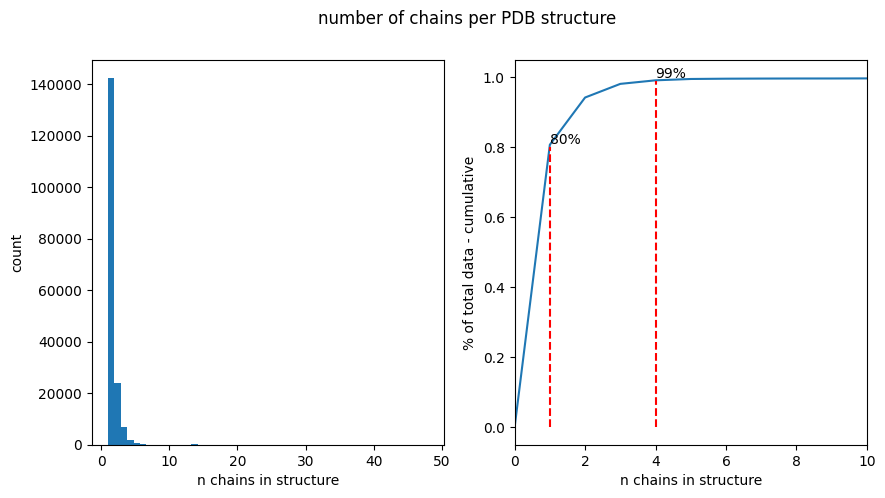

In [22]:
#lets explore how many separate chains per structure - meaning how many polymer entities per pdb_id
n_chains = df_pe.groupby('pdb_id').size()

fig, axes = plt.subplots(1,2, figsize=[10,5])

ax = axes[0]
ax.hist(n_chains, bins=50);
ax.set_xlabel('n chains in structure')
ax.set_ylabel('count')

#calculate cumsum the histogram data for counting number of pdb_id with x chains
cumsum = n_chains.to_frame().reset_index().groupby(0).size().cumsum()
cumsum = pd.concat([pd.Series((0)), cumsum]) #add dummy zero
cumsum /= cumsum.iloc[-1]

ax = axes[1]
 
ax.plot(cumsum)
ax.set_xlabel('n chains in structure')
ax.set_ylabel('% of total data - cumulative')

# ax.hlines([0.8, 0.99], 0, 50, color='red', linestyles='--')
ax.vlines([1, 4], [0, 0], [0.8, 0.99], color='red', linestyles='--')
ax.text(1, 0.81, '80%')
ax.text(4 ,1, '99%')
ax.set_xlim([0,10])

fig.suptitle('number of chains per PDB structure')

n_chains.to_frame().reset_index().groupby(0).size()

As seen in the above figure, 80% have single chain, and 99% has 5 chains or less.

We will start by training a model for structures with a single chain only.

Later on a model that take more than one chain can be trained.

In [23]:
#filter for single chains
s = df_pe.groupby('pdb_id').size()
singles_ids = set(s[s == 1].index)
df_pe = df_pe[df_pe.pdb_id.isin(singles_ids)]
df_entries = df_entries[df_entries.pdb_id.isin(singles_ids)]





In [24]:
#as we depend on the 'pdbx_details' feature as our label, lets remove instances the lack this feature
print(f'Out of {len(df_entries)} entries in current data, {len(df_entries.query("pdbx_details.isna()"))} lack pdbx details')


Out of 142352 entries in current data, 5866 lack pdbx details


In [25]:
#lets filter does out
df_entries = df_entries.query('pdbx_details.notna()')
df_pe = df_pe.query('pdbx_details.notna()')

As a POC, we want to train a model that predicts pH and Temp alone

Lets see how these features look like

We will start by looking at Nan values and filling them out

In [26]:
n = len(df_entries)
ph_miss = len(df_entries[df_entries.ph.isna()])
print(f'Out of {n} entries, {ph_miss} are missing pH ({100*ph_miss/n:.2f}%)')

Out of 136486 entries, 28732 are missing pH (21.05%)


# pH and Temp
Lets overview the pH and Temp in the data.



In [27]:
#lets fill the missing ph values by extracting the from the verbal description

def parse_ph_from_string(s):
    s = s.lower()
    matches =  re.findall(r'ph\s=*\s*?\d+(?:\.\d+)?', s)
    
    if len(matches) >=1 :
        v = matches[0].split(' ')[-1]
        v = v.replace('ph', '').replace('=', '').strip()
        v = float(v)
        if not 0.1 < v < 14:
            v = np.nan
        
    else:
        return np.nan

m = df_entries.ph.isna()
df_entries.loc[m, 'ph'] = df_entries.loc[m, 'pdbx_details'].apply(parse_ph_from_string)

n = len(df_entries)
n_missing_ph = df_entries.ph.isna().sum()

print(f'for {n_missing_ph} out of {n} we could not extract pH') 


for 28732 out of 136486 we could not extract pH


In [28]:
#we wil fill in some missing temp values
def parse_temp_from_string(s):
    s = s.lower()
    matches =  re.findall(r'temperature \d\d\dK?', s)
    
    if len(matches) > 0:
        return int(matches[0].split()[-1])
    else:
        return np.nan


m = df_entries.temp.isna()
df_entries.loc[m, 'temp'] = df_entries.loc[m, 'pdbx_details'].apply(parse_temp_from_string)

n = len(df_entries)
n_missing_temp = df_entries.temp.isna().sum()

print(f'for {n_missing_temp} out of {n} we could not extract temp') 



for 14584 out of 136486 we could not extract temp


Text(0.5, 1.0, 'temp distribution')

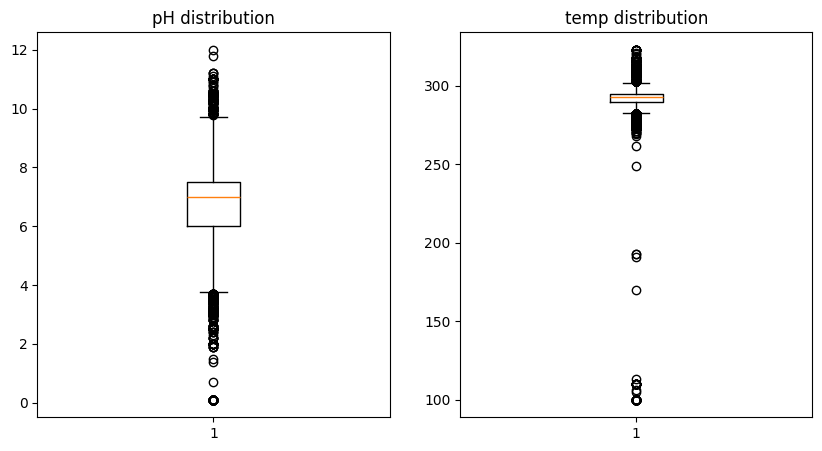

In [39]:
fig,axes = plt.subplots(1, 2, figsize=[10,5])

y = df_entries[df_entries.ph.notna()].ph
ax = axes[0]
ax.boxplot(y);
ax.set_title('pH distribution')

y = df_entries[df_entries.temp.notna()].temp
ax = axes[1]
ax.boxplot(y);
ax.set_title('temp distribution')




In [45]:
print(f"There are {(df_entries.temp < 250).sum()} data points with temp < 250 K (-23 C). " )

There are 87 data points with temp < 250 K (-23 C). 


# Filtering
For the sake of initial model, we will remove missing pH or Temp values.
The final model will be trained directly on the pdbx_detail label.

also, we will filter out temp < 250K as these are extremely low point and very little data points.